In [64]:
import numpy as np
import tensorflow as tf
import mne
import os
import sys
sys.path.append('../')
from utils.loader import unicorn_fs, load_dataset, generate_samples
from utils.feature_extraction import extract_features, calculate_baseline, baseline_correction
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt

mne.set_log_level(verbose='ERROR', return_old_level=False, add_frames=None)

dataset = {'dataset_name': 'dataset_prova_3', 'dataset_type': ['playing'], 'labels': ['relax', 'excited']}

NUM_CLASSES = len(dataset['labels'])

In [65]:
dataset_name = dataset['dataset_name']
dataset_type = dataset['dataset_type']
labels = dataset['labels']

save_data = True

window_duration = 4 # seconds
window_size = window_duration * unicorn_fs # samples
window_overlap = 0.875 # percentage

ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

for data_type in dataset_type:
    print(f'\nProcessing {dataset_name} - {data_type} dataset\n')

    dataset_path_name = dataset_name
    if '-' in dataset_name:
        dataset_path_name = dataset_name.split('-')[0]

    path_dataset = os.path.join('../data/dataset', dataset_path_name, data_type)
    # Read dataset
    dataset = load_dataset(path_dataset, labels)

    # Calculate baseline
    print('\n----baseline----')
    eeg_raw_baseline = dataset['baseline']
    eeg_samples_baseline = generate_samples(eeg_raw_baseline, window_size, window_overlap)
    baseline = calculate_baseline(eeg_samples_baseline)

    # Extract features and apply baseline correction
    eeg_features_list = []
    for i, label in enumerate(labels):
        print(f'\n\n----{label}----')
        # Generate samples
        eeg_raw = dataset[label]
        eeg_samples = generate_samples(eeg_raw, window_size, window_overlap)
        # Extract features
        eeg_features = extract_features(eeg_samples)
        # Apply baseline correction
        eeg_features_corrected = baseline_correction(eeg_features, baseline)
        eeg_features_list.append(eeg_features_corrected)


Processing dataset_prova_3 - playing dataset

Loading file: ../data/dataset\dataset_prova_3\playing\relax\relax.csv
Loading file: ../data/dataset\dataset_prova_3\playing\relax\relax_2.csv
Loading file: ../data/dataset\dataset_prova_3\playing\excited\excited.csv
Loading file: ../data/dataset\dataset_prova_3\playing\excited\excited_2.csv
Loading file: ../data/dataset\dataset_prova_3\playing\baseline\baseline.csv

----baseline----
EEG dimension: (58750, 8)
Sample dimension: (1000, 8)
Number of samples: 462
Processing sample: 462/462
Features dimension: (462, 40)


----relax----
EEG dimension: (57500, 8)
Sample dimension: (1000, 8)
Number of samples: 452
Processing sample: 452/452
Features dimension: (452, 40)


----excited----
EEG dimension: (57500, 8)
Sample dimension: (1000, 8)
Number of samples: 452
Processing sample: 452/452
Features dimension: (452, 40)


In [66]:
# Prepare the data for classification
X = np.concatenate(eeg_features_list)
y = np.concatenate([np.full((eeg_features.shape[0], NUM_CLASSES), ONE_HOT_ENCODED_CLASSES[i]) for i, eeg_features in enumerate(eeg_features_list)])


# Split the data into training, validation and test sets 
num_inputs = len(X)
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(TRAIN_SPLIT + 0.2 * num_inputs)


random_indexes = np.arange(num_inputs)
np.random.shuffle(random_indexes)
X_shuffled = X[random_indexes]
y_shuffled = y[random_indexes]

X_train, X_test, X_val = np.split(X_shuffled, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_val = np.split(y_shuffled, [TRAIN_SPLIT, TEST_SPLIT]) 

print(f'X shape: {X.shape}, y shape: {y.shape}\n\
X_train shape: {X_train.shape}, y_train shape: {y_train.shape}\n\
X_val shape: {X_val.shape}, y_val shape: {y_val.shape}\n\
X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 
X_val = scaler.transform(X_val)

X shape: (904, 40), y shape: (904, 2)
X_train shape: (542, 40), y_train shape: (542, 2)
X_val shape: (182, 40), y_val shape: (182, 2)
X_test shape: (180, 40), y_test shape: (180, 2)


In [67]:
# model definition 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance, 50 units = output shape
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
loss = tf.keras.losses.CategoricalCrossentropy() # 'mse'
metric = tf.keras.metrics.CategoricalAccuracy() # ['mae']
optimizer = 'adam' # 'sgd' 'adam'  'rmsprop'    
model.compile(optimizer=optimizer, loss=loss, metrics=metric)
batch_size = 8
today = datetime.datetime.now().strftime("%Y%m%d")  
hour = datetime.datetime.now().strftime("%H%M%S")
MODEL_PATH = f'../models/model_{today}_{hour}.h5'
print('MODEL PATH =', MODEL_PATH)

MODEL PATH = ../models/model_20240513_133239.h5


In [68]:
# model = tf.keras.models.load_model(MODEL_PATH)

# model training
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val))

# save model and its weights 
model.save(MODEL_PATH)  


Epoch 1/200
68/68 [==============================] - 1s 5ms/step - loss: 0.4822 - categorical_accuracy: 0.7786 - val_loss: 0.3181 - val_categorical_accuracy: 0.9231
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.3076 - categorical_accuracy: 0.9004 - val_loss: 0.2421 - val_categorical_accuracy: 0.9341
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.2470 - categorical_accuracy: 0.9096 - val_loss: 0.2240 - val_categorical_accuracy: 0.9286
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.2177 - categorical_accuracy: 0.9133 - val_loss: 0.1747 - val_categorical_accuracy: 0.9451
Epoch 5/200
68/68 [==============================] - 0s 2ms/step - loss: 0.1832 - categorical_accuracy: 0.9280 - val_loss: 0.1539 - val_categorical_accuracy: 0.9670
Epoch 6/200
68/68 [==============================] - 0s 2ms/step - loss: 0.1594 - categorical_accuracy: 0.9428 - val_loss: 0.1407 - val_categorical_accuracy: 0.9560
Epoch 7/20

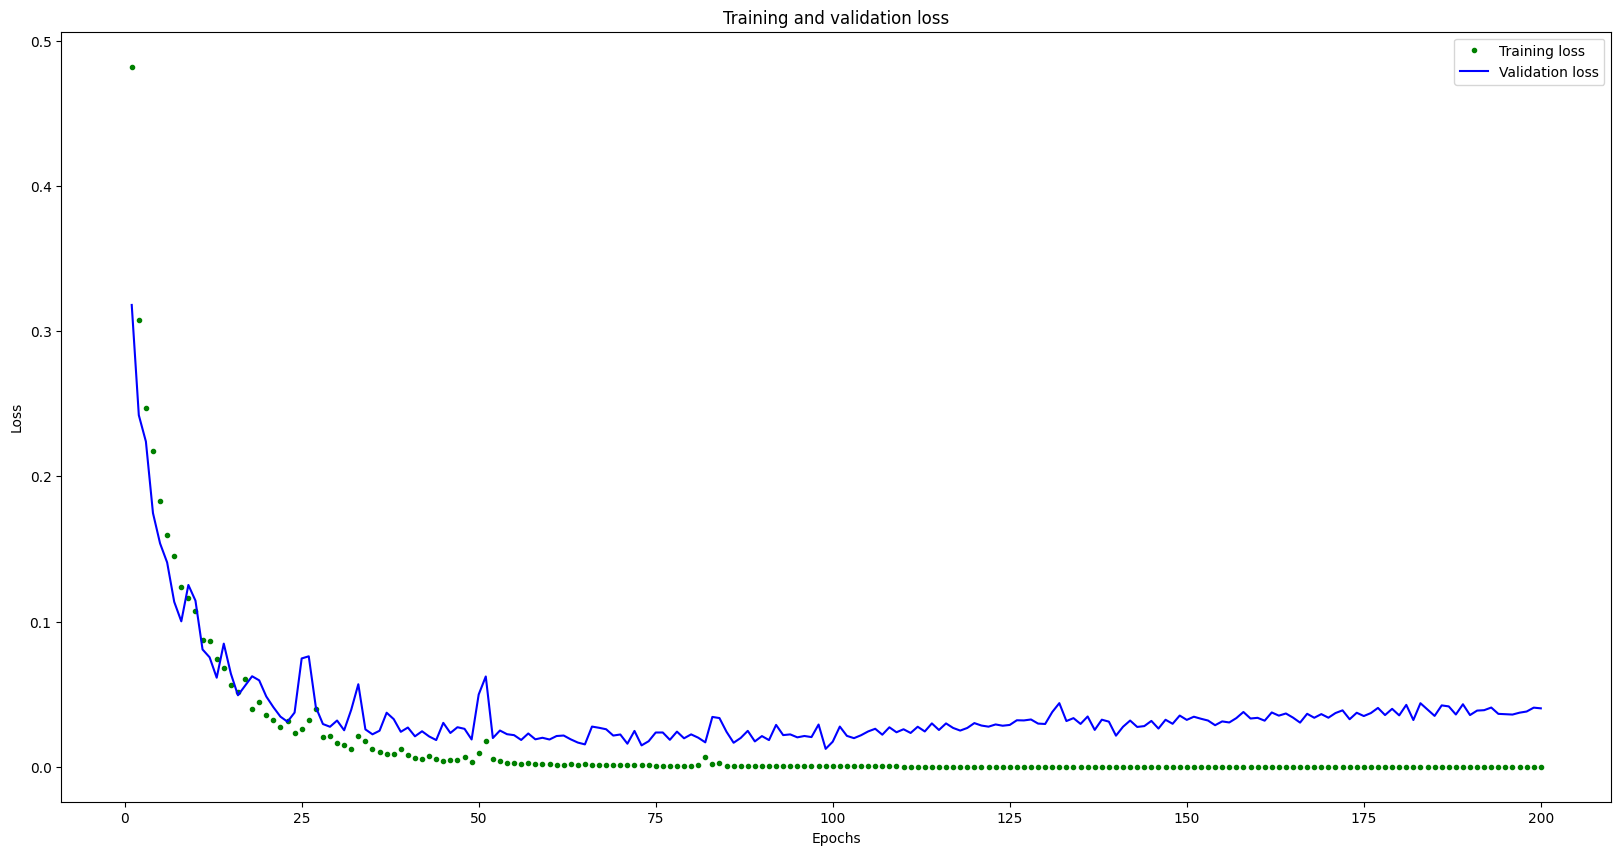

In [69]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
metric.reset_states()
predictions = model.predict(X_train)
metric.update_state(y_train, predictions)
print('Train Accuracy:', metric.result().numpy())

metric.reset_states()
predictions = model.predict(X_val)
metric.update_state(y_val, predictions)
print('Validation Accuracy:', metric.result().numpy())

metric.reset_states()
predictions = model.predict(X_test)
metric.update_state(y_test, predictions)
print('Test Accuracy:', metric.result().numpy())

17/17 [==============================] - 0s 1ms/step
Train Accuracy: 1.0
6/6 [==============================] - 0s 1ms/step
Validation Accuracy: 0.989011
6/6 [==============================] - 0s 2ms/step
Test Accuracy: 0.9722222


In [71]:
dataset = {'dataset_name': 'dataset_14', 'dataset_type': ['playing'], 'labels': ['relax', 'excited']}
NUM_CLASSES = len(dataset['labels'])

dataset_name = dataset['dataset_name']
dataset_type = dataset['dataset_type']
labels = dataset['labels']

save_data = True

window_duration = 4 # seconds
window_size = window_duration * unicorn_fs # samples
window_overlap = 0.875 # percentage

ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

for data_type in dataset_type:
    print(f'\nProcessing {dataset_name} - {data_type} dataset\n')

    dataset_path_name = dataset_name
    if '-' in dataset_name:
        dataset_path_name = dataset_name.split('-')[0]

    path_dataset = os.path.join('../data/dataset', dataset_path_name, data_type)
    # Read dataset
    dataset = load_dataset(path_dataset, labels)

    # Calculate baseline
    print('\n----baseline----')
    eeg_raw_baseline = dataset['baseline']
    eeg_samples_baseline = generate_samples(eeg_raw_baseline, window_size, window_overlap)
    baseline = calculate_baseline(eeg_samples_baseline)

    # Extract features and apply baseline correction
    eeg_features_list = []
    for i, label in enumerate(labels):
        print(f'\n\n----{label}----')
        # Generate samples
        eeg_raw = dataset[label]
        eeg_samples = generate_samples(eeg_raw, window_size, window_overlap)
        # Extract features
        eeg_features = extract_features(eeg_samples)
        # Apply baseline correction
        eeg_features_corrected = baseline_correction(eeg_features, baseline)
        eeg_features_list.append(eeg_features_corrected)


Processing dataset_14 - playing dataset

Loading file: ../data/dataset\dataset_14\playing\relax\relax.csv
Loading file: ../data/dataset\dataset_14\playing\excited\excited.csv
Loading file: ../data/dataset\dataset_14\playing\baseline\baseline.csv

----baseline----
EEG dimension: (58750, 8)
Sample dimension: (1000, 8)
Number of samples: 462
Processing sample: 462/462
Features dimension: (462, 40)


----relax----
EEG dimension: (28750, 8)
Sample dimension: (1000, 8)
Number of samples: 222
Processing sample: 222/222
Features dimension: (222, 40)


----excited----
EEG dimension: (28750, 8)
Sample dimension: (1000, 8)
Number of samples: 222
Processing sample: 222/222
Features dimension: (222, 40)


In [84]:
# Prepare the data for classification
X = np.concatenate(eeg_features_list)
y = np.concatenate([np.full((eeg_features.shape[0], NUM_CLASSES), ONE_HOT_ENCODED_CLASSES[i]) for i, eeg_features in enumerate(eeg_features_list)])

# Split the data into training, validation and test sets
num_inputs = len(X)
TRAIN_SPLIT = int(0.6 * num_inputs)

random_indexes = np.arange(num_inputs)
np.random.shuffle(random_indexes)
X_shuffled = X[random_indexes]
y_shuffled = y[random_indexes]

X_train, X_test, X_val = np.split(X_shuffled, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_val = np.split(y_shuffled, [TRAIN_SPLIT, TEST_SPLIT])

# Normalization
X_normalized = scaler.transform(X_test)


In [85]:
metric.reset_states()
predictions = model.predict(X_normalized)
metric.update_state(y_test, predictions)
print('Test Accuracy:', metric.result().numpy())

6/6 [==============================] - 0s 2ms/step
Test Accuracy: 0.5730337
